In [1]:
import os
from PIL import Image

input_folder = "images/xfx_512_512"
output_folder = "images/xfx_512_512_resized"

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        image = Image.open(input_path).convert("RGB")
        image = image.resize((512, 512), Image.LANCZOS)

        image.save(output_path)

        print(f"Resized: {filename}")

print("Done.")

Resized: xlgfx56_01.jpg
Resized: xlgfx30_06.jpg
Resized: xlgfx54_05 - Copy.jpg
Resized: xlgfx52_07.jpg
Resized: xlgfx42_07.jpg
Resized: xlgfx20_08.jpg
Resized: xlgfx23_06.jpg
Resized: xlgfx53_02.jpg
Resized: xlgfx23_10.jpg
Resized: xlgfx19_08.jpg
Resized: xlgfx31_08.jpg
Resized: xlgfx49_06.jpg
Resized: xlgfx52_06.jpg
Resized: xlgfx38_05.jpg
Resized: xlgfx42_05.jpg
Resized: xlgfx08_13.jpg
Resized: xlgfx56_06.jpg
Resized: xlgfx13_09.jpg
Resized: xlgfx45_05.jpg
Resized: xlgfx52_05.jpg
Resized: xlgfx51_08.jpg
Resized: xlgfx08_03.jpg
Resized: xlgfx08_01.jpg
Resized: xlgfx56_04.jpg
Resized: xlgfx43_03.jpg
Done.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import onnxruntime as ort
import pandas as pd
print("ONNX Runtime version:", ort.__version__)
ImagePath ='/home/aistudio/PytorchStableDiffusion/images/xfx_512_512'
WD14TaggerPath ='/home/aistudio/models/wd-v1-4-convnextv2-tagger-v2/model.onnx'
TagCSVPath = '/home/aistudio/models/wd-v1-4-convnextv2-tagger-v2/selected_tags.csv'
TriggerWords = 'xiaofeixiang'
session = ort.InferenceSession(WD14TaggerPath)
tags = pd.read_csv(TagCSVPath)
tagsList =tags['name'].tolist()
print(tagsList[:10])
fileList = os.listdir(ImagePath)
fileImageList = []
for fileName in fileList:
    if fileName.endswith('.jpg'):
        fileImageList.append(fileName)
fileList = fileImageList
print(fileList)
for fileName in fileList:    
    inputPath = os.path.join(ImagePath, fileName)
    print(inputPath)
    image = cv2.imread(inputPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)
    image = cv2.resize(image, (448, 448))
    #plt.imshow(image/255.0)
    #plt.show()
    #image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, axis=0)
    #print(image, image.shape)
    inputName = session.get_inputs()[0].name
    outPut = session.run(None,{inputName:image})
    print(type(outPut), len(outPut))
    print(outPut[0].shape)
    outPutIndexList =outPut[0][0]
    print(outPutIndexList)
    tagOutTextList = []
    for i,tagConfidene in enumerate(outPutIndexList):
        if tagConfidene > 0.2:
            tagOutTextList.append(tagsList[i].replace('_',' '))
    tagStr = TriggerWords
    for tag in tagOutTextList:
        tagStr = tagStr + ',' + tag       
    textPath = inputPath.split('.')[0] + '.txt'
    with open(textPath, 'w') as f:
        f.write(tagStr)
    print(tagStr)


ONNX Runtime version: 1.23.2
['general', 'sensitive', 'questionable', 'explicit', '1girl', 'solo', 'long_hair', 'breasts', 'looking_at_viewer', 'blush']
['xlgfx56_06.jpg', 'xlgfx56_04.jpg', 'xlgfx08_01.jpg', 'xlgfx08_13.jpg', 'xlgfx23_06.jpg', 'xlgfx08_03.jpg', 'xlgfx42_05.jpg', 'xlgfx49_06.jpg', 'xlgfx52_06.jpg', 'xlgfx54_05.jpg', 'xlgfx43_03.jpg', 'xlgfx31_08.jpg', 'xlgfx19_08.jpg', 'xlgfx51_08.jpg', 'xlgfx56_01.jpg', 'xlgfx13_09.jpg', 'xlgfx45_05.jpg', 'xlgfx53_02.jpg', 'xlgfx52_07.jpg', 'xlgfx52_05.jpg', 'xlgfx42_07.jpg', 'xlgfx38_05.jpg', 'xlgfx30_06.jpg', 'xlgfx23_10.jpg', 'xlgfx20_08.jpg']
/home/aistudio/PytorchStableDiffusion/images/xfx_512_512/xlgfx56_06.jpg
<class 'list'> 1
(1, 9083)
[6.2523067e-01 3.5084054e-01 3.4222007e-03 ... 1.0818243e-05 3.8146973e-06
 2.0563602e-06]
xiaofeixiang,general,sensitive,1girl,solo,long hair,looking at viewer,smile,bangs,shirt,black hair,animal ears,white shirt,upper body,outdoors,teeth,collared shirt,cat ears,grin,black eyes,colored skin,fang

In [29]:
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import CLIPTokenizer
class LoraDataSet(Dataset):
    def __init__(self):
        super(LoraDataSet,self).__init__()
        self.dataPath = '/home/aistudio/PytorchStableDiffusion/images/xfx_512_512'
        self.imageFileList = []
        self.textFileList = []
        for fileName in os.listdir(self.dataPath):
            if fileName.endswith('.jpg'):
                self.imageFileList.append(os.path.join(self.dataPath,fileName))
            
            if fileName.endswith('.txt'):
                self.textFileList.append(os.path.join(self.dataPath,fileName))
        
        self.preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((512,512)),
                transforms.ToTensor(),   # (0 255) -> (-1, 1)
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])# 
                ]) 
        self.promptTokenizer = CLIPTokenizer(vocab_file='../models/sd15models/vocab.json',
                                        merges_file='../models/sd15models/merges.txt')

    def __getitem__(self,index):    
        filePath = self.imageFileList[index]    
        img1 = cv2.imread(filePath)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = self.preprocess(img1)
        
        with open(self.textFileList[index],'r',encoding='utf-8') as f:
            prompt = f.read()
        promptTokens = self.promptTokenizer(prompt,padding='max_length',max_length=77,truncation=True,return_tensors='pt')['input_ids']
        attentionMask = self.promptTokenizer(prompt,padding='max_length',max_length=77,truncation=True,return_tensors='pt')['attention_mask']
        return img1,promptTokens,attentionMask

    def __len__(self):
        return len(self.imageFileList)
        
    

/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import CLIPTokenizer
from StableDiffusion.Utils import *
class LoraDataSet(Dataset):
    def __init__(self):
        super(LoraDataSet,self).__init__()
        self.dataPath = '/home/aistudio/PytorchStableDiffusion/images/xfx_512_512'
        self.preprocess = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((512,512)),
                transforms.ToTensor(),   # (0 255) -> (-1, 1)
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])# 
                ])
        self.promptTokenizer = CLIPTokenizer(vocab_file='../models/sd15models/vocab.json',
                                        merges_file='../models/sd15models/merges.txt')
        self.imageFileList = []
        self.textFileList = []
        for fileName in os.listdir(self.dataPath):
            if fileName.endswith('.jpg'):
                self.imageFileList.append(os.path.join(self.dataPath,fileName))
            
            if fileName.endswith('.txt'):
                self.textFileList.append(os.path.join(self.dataPath,fileName))
    
    def loadImageBatch(self,filePath:str,device='cuda')->torch.Tensor:
        img1 = cv2.imread(filePath)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        imgTensor = self.preprocess(img1)
        imgBatch = imgTensor[None, :, :, :]
        return imgBatch[0].to(device)   
    
    def getPromptTokens(self,prompt:str,device='cuda')->Tuple[torch.LongTensor,torch.LongTensor]:

        promptTokens = self.promptTokenizer(prompt,padding='max_length',
                                            max_length=77,truncation=True,return_tensors='pt')['input_ids']
        attentionMask = self.promptTokenizer(prompt,padding='max_length',
                                             max_length=77,truncation=True,return_tensors='pt')['attention_mask']
        return promptTokens[0].to(device),attentionMask[0].to(device)
    
    def __getitem__(self,index):    
        filePath = self.imageFileList[index]
        with open(self.textFileList[index],'r',encoding='utf-8') as f:
            prompt = f.read()
        imgTensor = self.loadImageBatch(filePath)
        promptTokens,attentionMask = self.getPromptTokens(prompt)

        return imgTensor,promptTokens,attentionMask

    def __len__(self):
        return len(self.imageFileList)

/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load sd1.5 model weights 

In [1]:
import os
import StableDiffusion.LoraDataSet
import StableDiffusion.DdpmSamplerTorch
import StableDiffusion.Utils
import importlib
importlib.reload(StableDiffusion.DdpmSamplerTorch)
importlib.reload(StableDiffusion.LoraDataSet)
importlib.reload(StableDiffusion.Utils)
from StableDiffusion.DdpmSamplerTorch import DdpmSamplerTorch
from StableDiffusion.LoraDataSet import LoraDataSet
from StableDiffusion.Utils import Utils
vaeEncoder,vaeDecoder,clipEncoder,diffusionProcess =Utils.loadModel()

/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ClipEncoder


# inject lora 

In [2]:
import torch.nn as nn
import torch
import StableDiffusion.LoraLayer
import StableDiffusion.LoraUtils
import importlib
importlib.reload(StableDiffusion.LoraLayer)
importlib.reload(StableDiffusion.LoraUtils)
from StableDiffusion.LoraLayer import LoraLayer
from StableDiffusion.LoraUtils import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
injectLora(diffusionProcess,rank = 16,alpha=32,
           #filterTuple=('in_proj','out_proj','k_proj','v_proj','q_proj'),
           filterTuple = ('in_proj','out_proj','k_proj','v_proj','q_proj'),
           device=device)
freezeModelWeights(clipEncoder)
freezeModelWeights(vaeDecoder)
freezeModelWeights(vaeDecoder)
freezeModelWeights(diffusionProcess)
checkModuleStatus(diffusionProcess,isShowAll=True)
checkModelMemory(vaeEncoder, "VAE Encoder")
checkModelMemory(vaeDecoder, "VAE Decoder")
checkModelMemory(clipEncoder, "CLIP Encoder")
checkModelMemory(diffusionProcess, "UNet/Diffusion")

Parameter Name                                               | Status     | Shape
-------------------------------------------------------------------------------------
time_embedding.linear_1.weight                               | ✅ TRAIN    | [1280, 320]
time_embedding.linear_1.bias                                 | ✅ TRAIN    | [1280]
time_embedding.linear_2.weight                               | ✅ TRAIN    | [1280, 1280]
time_embedding.linear_2.bias                                 | ✅ TRAIN    | [1280]
unet.encoders.0.0.weight                                     | ✅ TRAIN    | [320, 4, 3, 3]
unet.encoders.0.0.bias                                       | ✅ TRAIN    | [320]
unet.encoders.1.0.groupnorm_feature.weight                   | ✅ TRAIN    | [320]
unet.encoders.1.0.groupnorm_feature.bias                     | ✅ TRAIN    | [320]
unet.encoders.1.0.conv_feature.weight                        | ✅ TRAIN    | [320, 320, 3, 3]
unet.encoders.1.0.conv_feature.bias                        

In [5]:
import os
import torch
import matplotlib.pyplot as plt 
from IPython import display
import StableDiffusion.LoraDataSet
import StableDiffusion.DdpmSamplerTorch
import StableDiffusion.Utils
import StableDiffusion.LoraUtils
import importlib
importlib.reload(StableDiffusion.DdpmSamplerTorch)
importlib.reload(StableDiffusion.LoraDataSet)
importlib.reload(StableDiffusion.Utils)
importlib.reload(StableDiffusion.LoraUtils)
from StableDiffusion.Utils import Utils
from StableDiffusion.DdpmSamplerTorch import DdpmSamplerTorch
from StableDiffusion.LoraDataSet import LoraDataSet
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from StableDiffusion.LoraUtils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sampler = DdpmSamplerTorch()
sampler.to(device)
loraDataSet = LoraDataSet()
loraDataLoader = DataLoader(loraDataSet,batch_size=4,
                                shuffle=True,num_workers=0,drop_last=True,collate_fn=None)
loraDataSet.__len__()
img,promtTokens,attentionMask = loraDataSet[0]
print(img.shape,promtTokens.shape,attentionMask.shape)

vaeEncoder.eval()
vaeDecoder.eval()
clipEncoder.eval()
diffusionProcess.train()

trainableParamsList = []
for name,param in diffusionProcess.named_parameters():
    if param.requires_grad:
        #print(name,param.shape)
        trainableParamsList.append(param)  


lossHistory = []
epochLossHistory = []



optimizer = torch.optim.Adam(trainableParamsList, lr=1e-4)
EpochNum = 10
for epoch in tqdm(range(EpochNum),desc='Epoch'):
    epochLoss = 0.0
    for i,data in enumerate(tqdm(loraDataLoader)):
        img,promptTokens,attentionMask = data
        with torch.no_grad():
            latentImg = vaeEncoder(img)
        
        with torch.no_grad():
            clipOutputsPositive = clipEncoder(promptTokens,attentionMask)
        
        
        BatchSize,Channel,Height,Width = latentImg.shape

        noiseLatent = torch.randn(BatchSize,Channel,Height,Width,dtype=torch.float32,device=device)
        timeSteps =torch.randint(0,1000,(BatchSize,),device=device)
        #print(timeSteps.shape,timeSteps)
        latentImgNoised = sampler.addNoiseBatchTrain(latentImg,noiseLatent,timeSteps)
        timeEmb320 =Utils.getTimeEmbeddingBatch(timeSteps)
        timeEmb320 = sampler.numpy2Tensor(timeEmb320)
        #print(latentImgNoised.shape,clipOutputsPositive.shape,timeEmb320.shape)
        predictedNoise= diffusionProcess(latentImgNoised,clipOutputsPositive,timeEmb320)
        with torch.no_grad():        
            noisedImg =vaeDecoder(latentImgNoised)
            
        loss = nn.functional.mse_loss(predictedNoise,noiseLatent)
        
        lossHistory.append(loss.item())
        epochLoss = epochLoss + loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'epoch: {epoch}, iter: {i}, loss:{loss.item()}')
        
            
        #Utils.showBatchImage(img[:1])
        #Utils.showBatchImage(latentImg[:1,:3])
        #Utils.showBatchImage(noisedImg[:1])
    epochLoss = epochLoss / len(loraDataLoader)
    epochLossHistory.append(epochLoss)
    print(f'epoch: {epoch}, epochLoss:{epochLoss}')
    
    display.clear_output(wait=True)
    plt.figure(figsize= (10,5))
    plt.plot(epochLossHistory,label='epoch loss')    
    display.display(plt.gcf())
    plt.close()
           
writeLoraToFile(diffusionProcess)
        

torch.Size([3, 512, 512]) torch.Size([77]) torch.Size([77])


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

vae encoder input noise is none  use zeros


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 79.25 GiB of which 73.38 MiB is free. Process 1850 has 30.23 GiB memory in use. Including non-PyTorch memory, this process has 48.94 GiB memory in use. Of the allocated memory 48.18 GiB is allocated by PyTorch, and 266.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

token embedding shape torch.Size([1, 77, 768])
token embedding shape torch.Size([1, 77, 768])
input image is none,use random noise instead


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


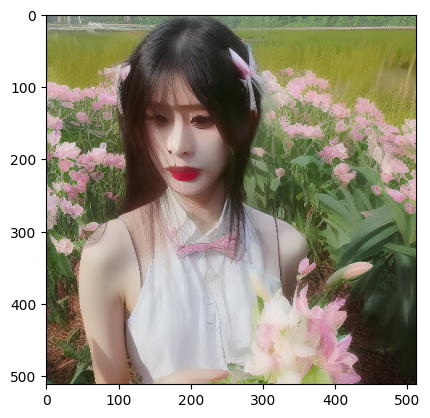

token embedding shape torch.Size([1, 77, 768])
token embedding shape torch.Size([1, 77, 768])
input image is none,use random noise instead


100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


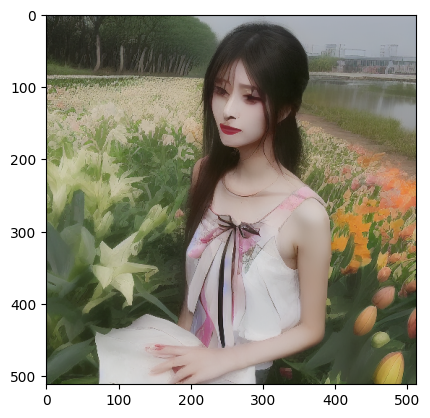

token embedding shape torch.Size([1, 77, 768])
token embedding shape torch.Size([1, 77, 768])
input image is none,use random noise instead


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


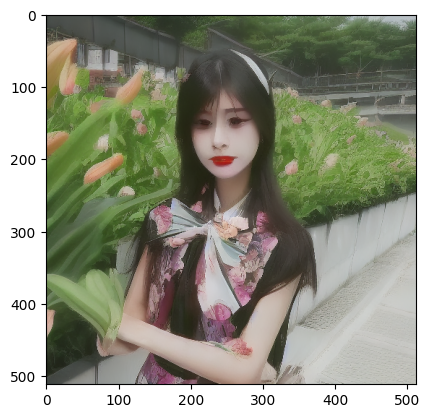

token embedding shape torch.Size([1, 77, 768])
token embedding shape torch.Size([1, 77, 768])
input image is none,use random noise instead


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


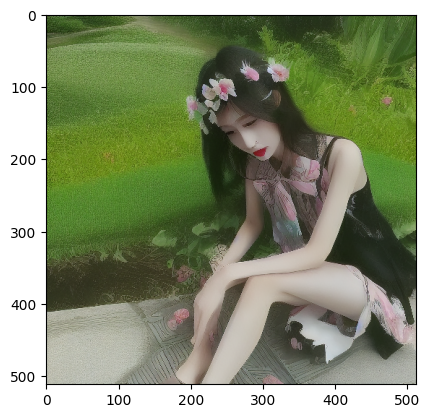

In [5]:
import numpy as np
import torch
import importlib
from tqdm import tqdm
import StableDiffusion.Utils
import StableDiffusion.GenPipe
importlib.reload(StableDiffusion.GenPipe)
from StableDiffusion.Utils import Utils
from StableDiffusion.GenPipe import GenPipe

genPipe = GenPipe(vaeEncoder,vaeDecoder,clipEncoder,diffusionProcess)



prompt ='xiaofeixiang,1girl, solo, flower, long hair, \
    dress, bare shoulders, upper body, \
        realistic, lily \(flower\), black eyes, black hair, brown hair, holding flower, lips, sleeveless, \
    looking at viewer, holding, wind, closed mouth, bouquet, blue dress'
prompt = 'xiaofeixiang,1girl'
promptNegative ='low quality, worst quality, blurry, out of focus, \
    jpeg artifacts, watermark,\
        text, logo, signature, oversharpened, \
            overexposed, underexposed, bad anatomy, \
                bad proportions, deformed, distorted, \
                    disfigured, mutated, extra limbs, extra arms,\
                        extra legs, extra fingers, fused fingers,\
                            missing fingers, long neck, cross-eyed, \
                                bad eyes, plastic skin, doll-like, cgi, 3d render'
GenNum=4
for i in range(GenNum):
    genPipe.seed = np.random.randint(10000)
    genPipe.numInferenceSteps =20
    imgStepList = genPipe.genImage(prompt,promptNegative)  

In [ ]:
trainable_params = [p for p in diffusionProcess.parameters() if p.requires_grad]
print(trainable_params)

In [ ]:
trainableParamsList = []
for name,param in diffusionProcess.named_parameters():
    if param.requires_grad:
        print(name,param.shape)
        trainableParamsList.append(param)  

optimizer = torch.optim.Adam(trainableParamsList, lr=1e-4)

In [ ]:
timeSteps =torch.randint(0,1000,(4,),device=device)
print(timeSteps)
timeSteps = timeSteps.cpu().numpy()
print(timeSteps)
BatchSize = timeSteps.shape[0]
t = timeSteps
t = t.reshape(BatchSize,1)
print(t)
#time = sampler.tensor2Numpy(timeSteps)
#timeEmbedding320 = Utils.getTimeEmbedding(time)    
#timeEmbedding320= sampler.numpy2Tensor(timeEmbedding320,device=device)


def getTimeEmbedding(timeStep:torch.Tensor)->np.ndarray:   
    t = timeStep.cpu().numpy()
    t = t[:,None]
    #print(t.shape)
    frequency = np.arange(0,160.0) 
    frequency = -frequency/160.0
    frequency = 10000**frequency    
    xk = t *frequency 
    #print(xk.shape)
    timeEmbeddingCos = np.cos(xk)
    timeEmbeddingSin = np.sin(xk)
    timeEmbedding = np.concatenate([timeEmbeddingCos,timeEmbeddingSin],axis=1)
    return timeEmbedding


timeSteps =torch.randint(0,1000,(4,),device=device)
timeEmb320 = getTimeEmbedding(timeSteps)
print(timeEmb320.shape)

In [25]:
#print(imgBatch.shape)
print(img.shape)
print(img)
print(promptTokens)
print(attentionMask)

print(img[0].shape)
print(promptTokens[0].shape)
print(attentionMask[0].shape)

torch.Size([2, 3, 512, 512])
tensor([[[[ 0.8588,  0.8510,  0.9608,  ...,  0.5608,  0.3176,  0.2078],
          [ 0.8902,  0.8745,  0.9686,  ...,  0.4902,  0.3569,  0.2941],
          [ 0.8980,  0.8824,  0.9451,  ...,  0.4196,  0.2863,  0.2235],
          ...,
          [ 0.2157,  0.1608,  0.1373,  ..., -0.3020, -0.2078, -0.2078],
          [ 0.2078,  0.1765,  0.1294,  ..., -0.2549, -0.1686, -0.1686],
          [ 0.1137,  0.1529,  0.1216,  ..., -0.3020, -0.2392, -0.2471]],

         [[ 0.7804,  0.7725,  0.8824,  ...,  0.3882,  0.1608,  0.0510],
          [ 0.8118,  0.7961,  0.8902,  ...,  0.3176,  0.2000,  0.1373],
          [ 0.8196,  0.8039,  0.8667,  ...,  0.2471,  0.1294,  0.0667],
          ...,
          [ 0.1529,  0.0980,  0.0745,  ..., -0.2314, -0.1373, -0.1373],
          [ 0.1451,  0.1137,  0.0667,  ..., -0.1843, -0.0980, -0.0980],
          [ 0.0510,  0.0902,  0.0588,  ..., -0.2314, -0.1686, -0.1765]],

         [[ 0.7020,  0.6941,  0.8039,  ...,  0.2078, -0.0275, -0.1373],
 